In [86]:
import numpy as np
import random

class SequenceLearningEnv:
    def __init__(self, sequence, distractor, max_errors):
        self.sequence = sequence
        self.distractor = distractor
        self.max_errors = max_errors
        self.state = 0  # Starting at the first element
        self.errors = 0

    def reset(self):
        self.state = 0
        self.errors = 0
        return self.state

    def step(self, action):
        if action == self.sequence[self.state]:
            reward = 1  # Correct choice
            self.state += 1  # Move to the next in sequence
            done = self.state == len(self.sequence)  # Check if sequence is completed
        else:
            reward = -1  # Incorrect choice
            self.state = max(0, self.state - 1)  # Move back one state, but not before the first
            self.errors += 1
            done = self.errors >= self.max_errors  # Check if max errors exceeded
        return self.state, reward, done

    def get_possible_actions(self):
        # Return all possible actions including the distractor, sorted in alphabetical order
        return sorted(set(self.sequence + self.distractor))

def q_learning_with_parameters(env, num_trials, learning_rate, discount_factor, epsilon, q_table=None):
    if q_table is None:
        q_table = np.zeros((len(env.sequence) + 1, len(env.get_possible_actions())))
    action_space = env.get_possible_actions()
    distractor_index = action_space.index("Z") 

    total_rewards = []
    error_counts = []
    success_trials = []
    distractor_q_values = []

    for trial in range(num_trials):
        state = env.reset()
        done = False
        total_reward = 0
        error_count = 0

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = random.choice(action_space)
            else:
                action_index = np.argmax(q_table[state])
                action = action_space[action_index] if action_index < len(action_space) else env.distractor

            next_state, reward, done = env.step(action)
            total_reward += reward
            if reward == -1:
                error_count += 1

            old_value = q_table[state, action_space.index(action)]
            next_max = np.max(q_table[next_state])
            q_table[state, action_space.index(action)] = old_value + learning_rate * (reward + discount_factor * next_max - old_value)

            state = next_state

        total_rewards.append(total_reward)
        error_counts.append(error_count)
        success_trials.append(1 if env.state == len(env.sequence) else 0)
         # Record Q-values for the distractor at the end of each trial
        distractor_q_values.append([q_table[s][distractor_index] for s in range(len(env.sequence))])

    return {
        "Updated Q-Table": q_table,
        "Total Rewards": total_rewards,
        "Error Counts": error_counts,
        "Success Trials": success_trials,
        "Distractor Q-Values": distractor_q_values
    }



In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_success_rate(success_rates):
    plt.figure(figsize=(10, 6))
    plt.plot(success_rates, label='Success Rate')
    plt.xlabel('Trial')
    plt.ylabel('Success Rate')
    plt.title('Success Rate Over Trials')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_reward(rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label='Success Rate')
    plt.xlabel('Trial')
    plt.ylabel('Success Rate')
    plt.title('Success Rate Over Trials')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_distractor_q_values(distractor_q_values):
    plt.figure(figsize=(12, 6))
    for state_q_values in zip(*distractor_q_values):
        plt.plot(state_q_values, label=f'State {state_q_values.index(state_q_values[0])}')
    plt.xlabel('Trial')
    plt.ylabel('Q-value for Distractor "Z"')
    plt.title('Distractor Q-Values Over Trials')
    plt.legend(title="State")
    plt.grid(True)
    plt.show()


def plot_average_reward(total_rewards, block_breakpoint):
    # Calculate the overall average reward up to each point
    average_rewards = [sum(total_rewards[:i+1])/(i+1) for i in range(len(total_rewards))]

    # Calculate the moving average with a window of 5 trials (2 before, 2 after)
    moving_averages = []
    for i in range(len(total_rewards)):
        start_index = max(0, i - 1)
        end_index = min(len(total_rewards), i + 4)  # Add 1 because the range is exclusive on the right side
        window = total_rewards[start_index:end_index]
        window_average = sum(window) / len(window)
        moving_averages.append(window_average)

    plt.figure(figsize=(10, 6))
    plt.plot(average_rewards, label='Overall Average Reward', alpha=0.5)  # Slightly transparent to distinguish from moving average
    plt.plot(moving_averages, label='5-Trial Moving Average', color='red')

    # Draw a vertical dashed line at the block breakpoint
    if block_breakpoint is not None and 0 <= block_breakpoint < len(total_rewards):
        plt.axvline(x=block_breakpoint, color='gray', linestyle='--', label='Block Change')

    plt.xlabel('Trial')
    plt.ylabel('Average Reward')
    plt.title('Average Reward Over Trials')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_moving_average_success_rate(success_trials, block_breakpoint):
    # Calculate the moving average success rate with a window of 5 trials (2 before, 2 after)
    moving_averages = []
    for i in range(len(success_trials)):
        start_index = max(0, i - 2)
        end_index = min(len(success_trials), i + 3)  # Add 1 because the range is exclusive on the right side
        window = success_trials[start_index:end_index]
        window_average = sum(window) / len(window)
        moving_averages.append(window_average)
    

    plt.figure(figsize=(10, 6))
        # Draw a vertical dashed line at the block breakpoint
    if block_breakpoint is not None and 0 <= block_breakpoint < len(success_trials):
        plt.axvline(x=block_breakpoint, color='gray', linestyle='--', label='Block Change')

    plt.plot(moving_averages, label='5-Trial Moving Average Success Rate', color='green')
    plt.xlabel('Trial')
    plt.ylabel('Success Rate')
    plt.title('5-Trial Moving Average Success Rate Over Trials')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_errors_per_trial(error_counts):
    plt.figure(figsize=(10, 6))
    plt.plot(error_counts, label='Errors per Trial')
    plt.xlabel('Trial')
    plt.ylabel('Number of Errors')
    plt.title('Errors per Trial Over Trials')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_action_confidence(action_confidences):
    plt.figure(figsize=(10, 6))
    plt.plot(action_confidences, label='Action Confidence')
    plt.xlabel('Trial')
    plt.ylabel('Average Max Q-Value')
    plt.title('Action Selection Confidence Over Trials')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_q_table(q_table, action_labels):

    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(q_table, annot=True, cmap="coolwarm", fmt=".2f",
                     xticklabels=action_labels, yticklabels=[f"State {i}" for i in range(q_table.shape[0])])
    plt.title("Q-table Heatmap")
    plt.xlabel("Actions")
    plt.ylabel("States")
    ax.set_aspect("equal")
    plt.show()


[[ 1.66624588  0.          0.         -0.04177575  0.          0.        ]
 [-0.1142791   1.6115209   0.          0.         -0.04177575  0.        ]
 [-0.0905     -0.08195     1.52548502  0.          0.          0.        ]
 [-0.0905     -0.08195    -0.074255    1.27400578  0.          0.        ]
 [-0.0905     -0.08195    -0.08813159 -0.0673295   0.77123208  0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]


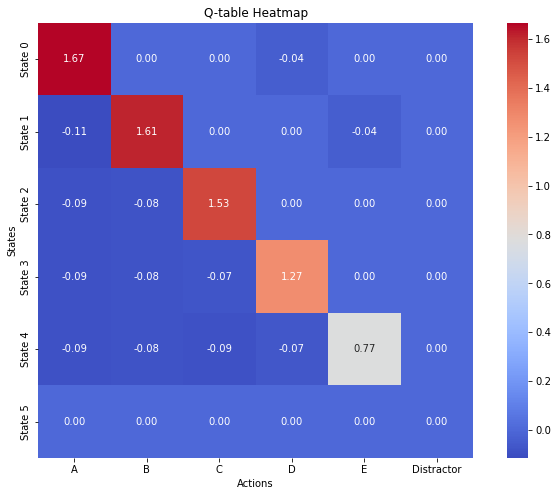

Combined Total Rewards: [3, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, -1, -1, -2, -3, 0, -2, -1, -2, -1, 0, 2, -4, -1, 0, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Combined Error Counts: [10, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 0, 0, 0, 1, 0, 2, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 1, 1, 0, 5, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1]
Final Q-Table:
 [[ 4.38792787  0.65179892  0.34085971  0.46592815  0.60004416  0.42345313]
 [ 0.2879663   0.34363185  0.07656499  3.65897428  0.13590648  0.9719002 ]
 [ 0.20907462  0.14345086  2.83840806  0.7025424

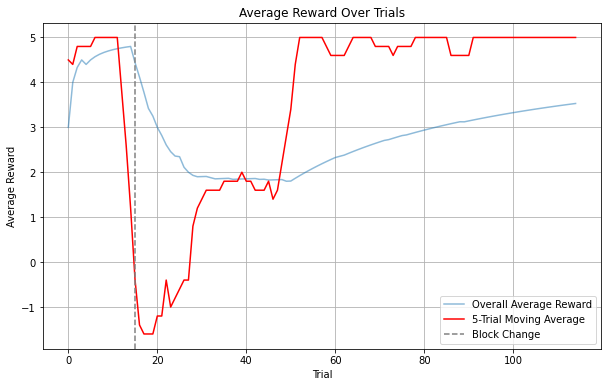

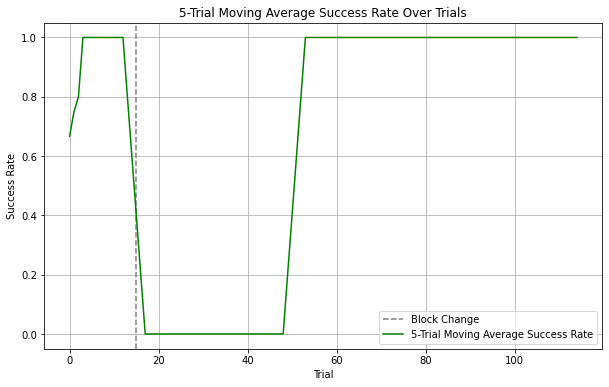

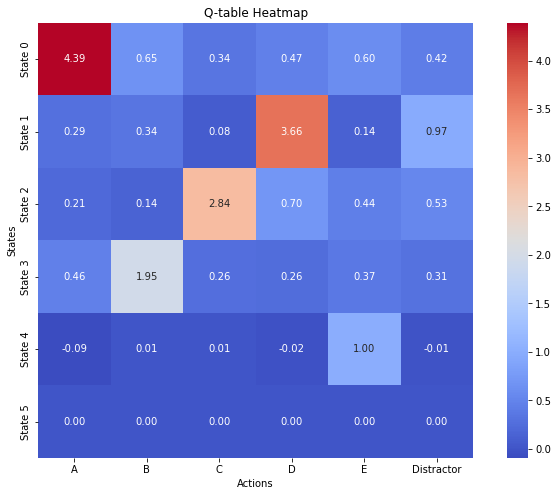

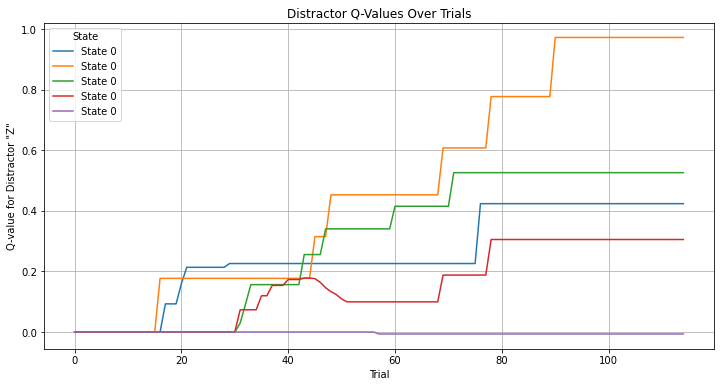

In [87]:
# Example of usage
action_labels = ["A", "B", "C", "D", "E", "Distractor"] 
env = SequenceLearningEnv("ABCDE", "Z", 10)  # Initial environment setup
learning_rate = 0.1
discount_factor = 0.95
epsilon = 0.1
num_trials = 15 # Total number of trials

# Train on the first sequence
first_phase_metrics = q_learning_with_parameters(env, num_trials, learning_rate, discount_factor, epsilon)
first_q_table = first_phase_metrics["Updated Q-Table"]
print(first_q_table)
plot_q_table(first_q_table, action_labels)
# Change the sequence and continue training with the updated Q-table
env.sequence = "ADCBE"
second_phase_metrics = q_learning_with_parameters(env, 100, learning_rate, discount_factor, epsilon, q_table=first_phase_metrics["Updated Q-Table"])

# Combined metrics
combined_total_rewards = first_phase_metrics["Total Rewards"] + second_phase_metrics["Total Rewards"]
combined_error_counts = first_phase_metrics["Error Counts"] + second_phase_metrics["Error Counts"]
combined_success_trials = first_phase_metrics["Success Trials"] + second_phase_metrics["Success Trials"]
combined_distractor_q_values = first_phase_metrics["Distractor Q-Values"] + second_phase_metrics["Distractor Q-Values"]
final_q_table = second_phase_metrics["Updated Q-Table"]

# Output metrics
print("Combined Total Rewards:", combined_total_rewards)
print("Combined Error Counts:", combined_error_counts)
print("Final Q-Table:\n", final_q_table)

plot_average_reward(combined_total_rewards, num_trials)
plot_moving_average_success_rate(combined_success_trials, num_trials)


plot_q_table(final_q_table, action_labels)

plot_distractor_q_values(combined_distractor_q_values)